## 목표
- 온도와 압력에 의한 패턴 분석 -> 고장 추세 예측
- 불량품 양품 예측

In [1]:
# pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('/disk2/output/input_58.csv')

## 데이터 형태(초기)
- (19429, 17)
- event_time: 제품에 레이저로 코드를 각인한 시각
- result: 양품=0, 불량품=1
- 1_1 : 온도_압력
- *온도(1 or 8), 압력(1 ~ 12)
- 각 행에 '리스트', 결국 str 형태로 총 601개의 값이 존재)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19429 entries, 0 to 19428
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event_time  19429 non-null  object 
 1   result      19429 non-null  int64  
 2   1_1         12884 non-null  object 
 3   1_2         12883 non-null  object 
 4   1_3         12884 non-null  object 
 5   1_4         0 non-null      float64
 6   1_6         0 non-null      float64
 7   1_7         0 non-null      float64
 8   1_8         11959 non-null  object 
 9   1_9         10970 non-null  object 
 10  1_10        10507 non-null  object 
 11  1_11        0 non-null      float64
 12  1_12        0 non-null      float64
 13  8_1         12848 non-null  object 
 14  8_2         12653 non-null  object 
 15  8_3         12652 non-null  object 
 16  8_4         12848 non-null  object 
dtypes: float64(5), int64(1), object(11)
memory usage: 2.5+ MB


In [5]:
df.shape

(19429, 17)

In [6]:
df.head(1)

,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


## 전처리1. Null 제거
#### 열
- 과정 : nan으로 이루어진 열이라고 예상되는 값에 대해서 null값을 세어봄.
- 결과 : 총 5개의 열이 null로만 이루어진 값이기에 drop하여 (19429, 12)로 수정
#### 행
- 과정 : df[:,'1_1':'8_4']에 대해서 null이 10인 경우(event_time, result 제외) 행 drop
- 결과 : 6545개의 행이 null로만 이루어진 값이므로 제거하여 (12884, 12)로 수정

In [7]:
float_col = []
for col in ['1_4', '1_6', '1_7', '1_11', '1_12']:
    total_nan_values = df[col].isnull().sum().sum()
    print (total_nan_values, end = ', ')

19429, 19429, 19429, 19429, 19429, 

In [8]:
df.drop(columns= ['1_4', '1_6', '1_7', '1_11', '1_12'], inplace=True)
df.shape

(19429, 12)

In [9]:
row_index = []
for i in range(0,19429):
    # print(df.loc[i, '1_1':'8_4'])
    total_nan_values = df.loc[i, '1_1':'8_4'].isnull().sum()
    if total_nan_values == 10:
        row_index.append(i)
print(len(row_index))

6545


In [10]:
for num in row_index:
    df.drop(index=num, axis=0, inplace=True)
print(df.shape)

(12884, 12)


In [11]:
# import ast
# import numpy as np

# # Assuming df is your DataFrame containing the data
# data_str = df.loc[7][2]

# # Replace NaN with None
# data_str_cleaned = str(data_str).replace('nan', 'None')

# # Use ast.literal_eval to safely evaluate the cleaned string
# data_list = ast.literal_eval(data_str_cleaned)

# # Convert None back to numpy NaN
# data_array = np.array(data_list)
# data_array[data_array == None] = np.nan

# print(data_array)


## 전처리2. each 데이터(601개)처리
1. str -> list
2. nan -> 0
3. len(data) = 601개로 맞춤 (0으로 채우기)
4. event_time기준으로 index정리

In [12]:
df.columns

Index(['event_time', 'result', '1_1', '1_2', '1_3', '1_8', '1_9', '1_10',
       '8_1', '8_2', '8_3', '8_4'],
      dtype='object')

In [13]:
# str-> list & 0 

def convert_str_to_array(data_str):
    # Handle string representations of lists with 'nan' values
    if isinstance(data_str, str):
        data_list = data_str.replace('[', '').replace(']', '').split(', ')
        data_list = [float(x) if x != 'nan' else np.nan for x in data_list]
        data_array = np.array(data_list)
    else:
        data_array = np.array(data_str)

    # Convert NaN values to 0
    data_array[np.isnan(data_array)] = 0

    return data_array

# Specify the columns you want to apply the conversion to
columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

# Apply the conversion to the specified columns for all rows
for col in columns_to_convert:
    df[col] = df[col].apply(convert_str_to_array)

# Print the updated DataFrame
df.head(2)


,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-10-06 02:30:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
# # 2. nan -> 0

# # print(data_array_cleaned)
# def nan2zero(convert_data):
#     if isinstance(convert_data, float):  # If it's a single float value
#         return 0 if np.isnan(convert_data) else convert_data
#     else:  # If it's an array
#         data_array_float = convert_data.astype(float)
#         data_array_cleaned = np.nan_to_num(data_array_float, nan=0)
#         return data_array_cleaned
    
# columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

# for col in columns_to_convert:
#     df[col] = df[col].apply(nan2zero)
    
# print('done')

In [15]:
# 3. len(data) = 601개로 맞춤 (0으로 채우기)

list_601 = [0.0] * 601
array_601 = np.array(list_601) 
# print(data_array_cleaned)
def arr_601(convert_data):
    if isinstance(convert_data, float):  # If it's a single float value
        return array_601  # Replace 0 with the predefined list 'list_601'
    else:
        return convert_data
    
columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

for col in columns_to_convert:
    df[col] = df[col].apply(arr_601)
df.head(1)

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
for time in df['event_time']:
    new_time = pd.to_datetime(time)
    time = new_time
df.shape

(12884, 12)

In [17]:
# 4. event_time기준으로 index정리
df.sort_values(by='event_time', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(1)

(12884, 12)


,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### 최종 drop
- 리스트 요소가 601개가 아닌 경우 존재
- 총 304개로 삭제
- 최종 df.shape = (12850,12)

In [18]:
strange_indices = {}  # 각 열의 이상한 경우의 인덱스를 저장할 딕셔너리 초기화

strange_index = []
for j in range(2, 12):
  # 현재 열의 이상한 경우의 인덱스를 저장할 리스트 초기화
    for i in range(12884):
        ex = df.iloc[i][j]
        len_ex = len(ex)
        if j ==2: 
            if len_ex != 601:
                strange_index.append(i)
        if j != 2:  # 첫 번째 열 이후로는 이전 열의 이상한 인덱스에 현재 열의 이상한 인덱스를 추가
            if len_ex != 601:
                strange_index.append(i)
    # strange_indices[j] = list(set(strange_index))  # 이상한 경우의 인덱스를 딕셔너리에 저장
real_strange_index = list(set(strange_index))
print(real_strange_index)
print(len(real_strange_index))

for num in real_strange_index:
    df.drop(index=num, axis=0, inplace=True)
print(j,'열의 shape = ',df.shape)

[7169, 7170, 8201, 10761, 5646, 12818, 5651, 10772, 10773, 12819, 12820, 4120, 4121, 11801, 11802, 11294, 35, 36, 3110, 3111, 3112, 10282, 7214, 9263, 1584, 1585, 11314, 3123, 3635, 3636, 5686, 11316, 12850, 12347, 10812, 12348, 3653, 8263, 11335, 4173, 4174, 4175, 3152, 3153, 3154, 5712, 11346, 597, 598, 599, 5719, 8278, 11350, 11351, 6237, 6238, 2655, 4710, 8807, 3182, 3183, 3184, 3185, 3697, 11375, 8820, 11376, 12404, 8826, 123, 124, 3198, 1663, 1664, 1665, 1666, 8321, 8322, 6278, 6790, 5624, 5769, 6799, 3216, 10897, 11407, 11408, 5781, 2711, 11424, 11425, 5799, 9895, 8364, 11956, 10423, 8687, 3262, 8688, 5825, 8689, 12486, 12487, 7672, 8690, 7164, 721, 722, 5332, 5333, 7380, 5847, 10457, 8922, 8185, 8415, 9951, 5345, 5346, 5347, 5348, 5349, 1254, 1255, 3815, 3816, 6378, 6379, 8188, 2285, 7405, 8427, 8428, 10472, 9615, 12024, 250, 251, 6910, 2816, 2817, 3845, 775, 776, 777, 9991, 10504, 7482, 12553, 12554, 10000, 1809, 7483, 9489, 9490, 1813, 1814, 1815, 9491, 12567, 10011, 10012, 9

## 데이터 시각화
- 예상 : 불량품과 양품 사이 구분될 만한 특징이 있을 것
- 실제 : 양품사이에서도 각기 다른 추세를 보임 

601


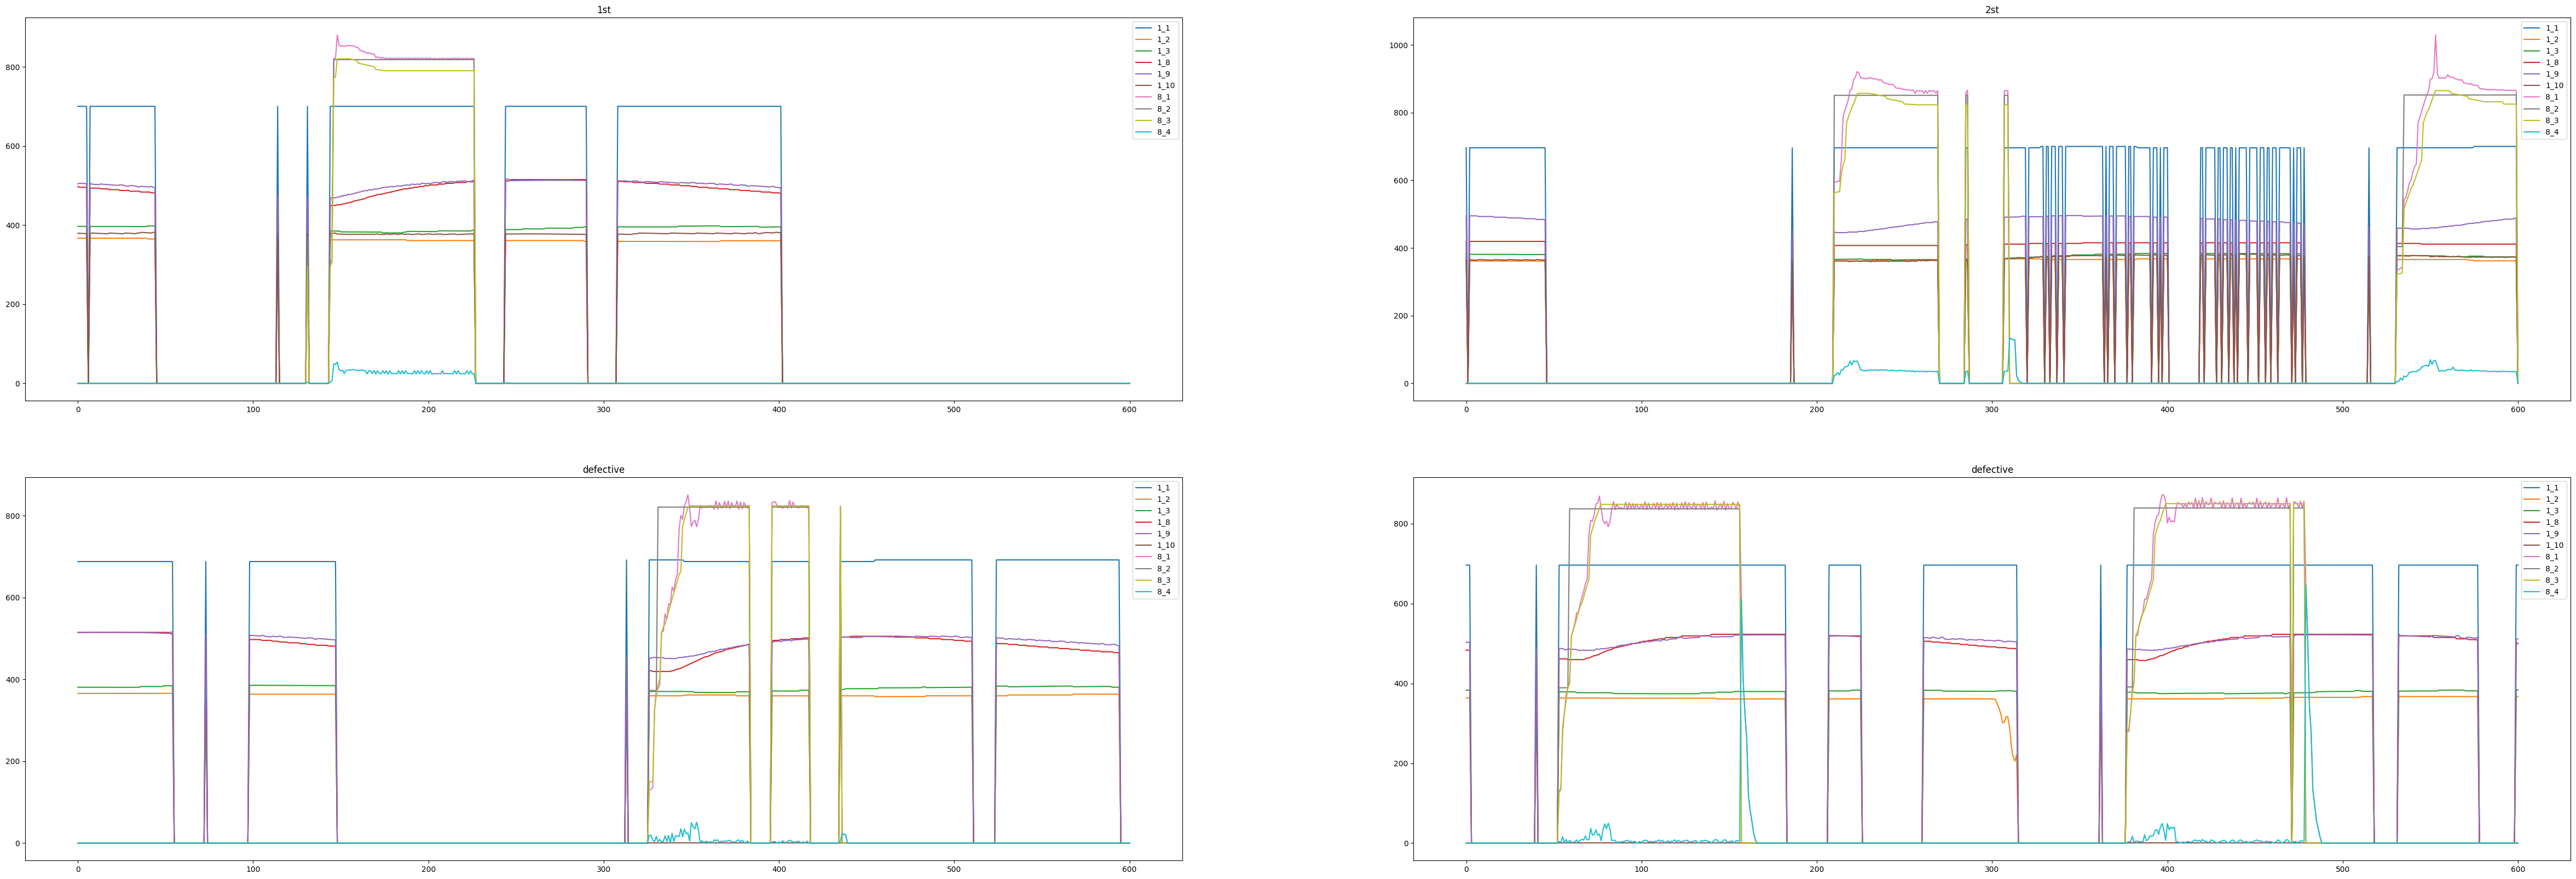

In [19]:
import matplotlib.pyplot as plt

x_time = []
for i in range(601):
    x_time.append(i)
print(len(x_time))

columns = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
plt.figure(figsize=(60,20))

plt.subplot(2, 2, 1)
for i in range(0,10) :
    y = df.loc[0][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i]) 
plt.title('1st')
plt.legend()


# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 2)
for i in range(0,10) :
    y = df.loc[1][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('2st')
plt.legend()

# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 3)
for i in range(0,10) :
    y = df.loc[12872][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('defective')
plt.legend()


# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 4)
for i in range(0,10) :
    y = df.loc[12838][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('defective')
plt.legend()


## 데이터 전처리의 문제점
- 불량품과 양품 사이 구별할만한 뚜렷한 추세가 보이지 않음
- 최대최소 정규화(논문) 적용 불가능 -> 대신 정규화라도 해야하나

## 불균형 데이터
- 대락 5:1정도 

Index([0, 1], dtype='int64', name='result') [10250  2330]


<BarContainer object of 2 artists>

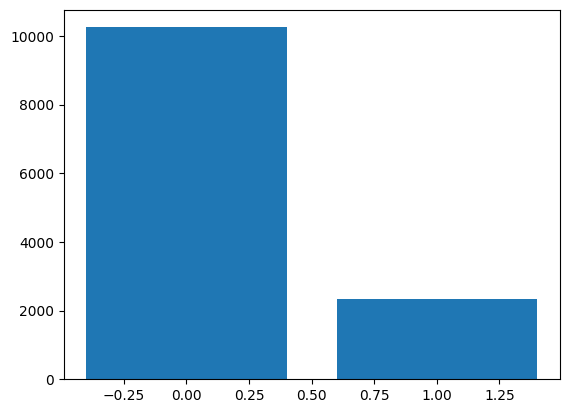

In [20]:
y_cla = df['result'].value_counts()
y_cla_ind = y_cla.index
y_cla_val = y_cla.values
print(y_cla_ind, y_cla_val)

plt.bar(y_cla_ind, y_cla_val)

# 최종데이터

In [21]:
df.head(1)

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# df -> data

In [22]:
import copy
data = df.copy(deep=True)

In [23]:
# data.to_csv('./copied_data.csv', sep=',')

In [24]:
data.head()

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-08-19 15:45:00,0,"[696.0, 0.0, 696.0, 696.0, 696.0, 696.0, 696.0...","[361.55, 0.0, 361.55, 361.55, 361.6, 361.6, 36...","[381.5, 0.0, 381.5, 381.4, 381.4, 381.3, 381.3...","[419.425, 0.0, 419.425, 419.425, 419.425, 419....","[495.1, 0.0, 495.1, 495.0, 495.0, 495.0, 495.0...","[365.5, 0.0, 365.1, 364.8, 364.6, 364.3, 364.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-08-22 01:09:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-08-22 01:25:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700...","[362.05, 362.05, 362.05, 362.05, 362.05, 362.0...","[408.2, 408.2, 408.2, 408.2, 408.2, 408.2, 408...","[52.928, 52.928, 52.928, 53.178, 53.178, 53.42...","[516.8, 516.8, 518.4, 517.6, 519.2, 518.4, 517...","[392.45, 392.45, 392.3, 392.3, 392.2, 392.15, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,2022-08-22 01:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
df.tail()

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
12879,2023-07-04 16:18:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12880,2023-07-04 16:23:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12881,2023-07-04 16:28:00,0,"[692.0, 692.0, 692.0, 692.0, 692.0, 692.0, 692...","[363.6, 363.6, 363.6, 363.6, 363.6, 363.6, 363...","[380.1, 380.1, 380.1, 380.1, 380.1, 380.1, 380...","[499.425, 499.425, 499.425, 499.425, 499.425, ...","[507.9, 507.4, 507.0, 506.8, 506.5, 506.2, 507...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12882,2023-07-04 18:02:00,0,"[696.0, 696.0, 696.0, 696.0, 696.0, 696.0, 696...","[360.95, 360.95, 360.95, 360.95, 360.95, 360.9...","[389.3, 389.3, 389.3, 389.2, 389.2, 389.2, 389...","[495.425, 495.425, 495.425, 495.425, 495.425, ...","[497.3, 494.9, 494.6, 494.3, 494.0, 495.4, 495...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12883,2023-07-04 21:48:00,0,"[696.0, 696.0, 696.0, 696.0, 696.0, 696.0, 696...","[360.7, 360.7, 360.7, 360.7, 360.7, 360.7, 360...","[377.3, 377.3, 377.3, 377.3, 377.3, 377.3, 377...","[493.425, 495.425, 497.425, 497.425, 499.425, ...","[489.9, 491.4, 490.2, 493.4, 492.1, 493.2, 494...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[819.0, 818.0, 818.0, 821.0, 808.0, 820.0, 807...","[819.0, 819.0, 819.0, 819.0, 819.0, 819.0, 819...","[822.0, 822.0, 822.0, 822.0, 822.0, 822.0, 822...","[3.0, 4.0, 4.0, 1.0, 8.0, 2.0, 9.0, 1.0, 16.0,..."


In [25]:
data.shape

(12580, 12)

In [26]:
data.drop(columns = ['event_time'], inplace = True)
data.head(1)

,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
y = data['result']
X = data.drop(['result'], axis = 1)
X.head(1)

,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
# dataset -> 3D
def temporalize(XX):
    X = []
    # scaler = MinMaxScaler()
    for i in range(XX.shape[0]):
        end = []
        for j in range(0, 601):
            st = []
            for t in range(0, 10):
                zero = XX[i,t][j]
                st.append(zero)
            end.append(st)
        X.append(end)
    
    X = np.array(X)
    
    return X
X_3D = temporalize(X.values)

print("X_3D: ", X_3D.shape)

subset = X_3D[:5, :, :]
print(subset)

X_3D:  (12580, 601, 10)
[[[700.   366.85 396.6  ...   0.     0.     0.  ]
  [700.   366.85 396.6  ...   0.     0.     0.  ]
  [700.   366.85 396.7  ...   0.     0.     0.  ]
  ...
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]]

 [[696.   361.55 381.5  ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [696.   361.55 381.5  ...   0.     0.     0.  ]
  ...
  [700.   362.05 373.6  ... 852.   825.    36.  ]
  [700.   362.05 373.5  ... 852.   825.    34.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]]

 [[  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  ...
  [696.   363.65 417.6  ...   0.     0.     1.  ]
  [696.   363.65 417.6  ...   0.     0.     1.  ]
  [696.   363.65 417.7  ...   0.     0.     1.  ]]

 [[700.   362.05 408.2  ...   0.     0.     1.  ]
  

In [31]:
print("X_3D: ", X_3D.shape)
print("y: ", y.shape)

X_3D:  (12580, 601, 10)
y:  (12580,)


# (12580*601,1)인 전체 데이터 만들기

In [32]:
X_2D = X_3D.reshape(-1, 10)
X_2D.shape
X_2D_df = pd.DataFrame(X_2D)

In [33]:
# pandas Series를 numpy 배열로 변환
y_array = y.to_numpy()

# 반복 횟수 지정
repeat_count = 601

# 데이터 반복 및 크기 확장
reshaped_y = np.repeat(y_array, repeat_count).reshape(-1, 1)

# 결과 확인
print(reshaped_y.shape)
reshaped_y_df = pd.DataFrame(reshaped_y)

(7560580, 1)


In [34]:
# 데이터프레임을 시간 열을 기준으로 정렬합니다.
from datetime import datetime, timedelta
timestamp_df = df['event_time']

# 새로운 데이터프레임 초기화
reshaped_datatime = pd.DataFrame(columns=['event_time'])

for i in timestamp_df:
    original_datetime = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    new_datetimes = [original_datetime + timedelta(seconds=num) for num in range(601)]
    new_df = pd.DataFrame({'event_time': new_datetimes})
    reshaped_datatime = pd.concat([reshaped_datatime, new_df], ignore_index=True)

# 결과 확인
print(reshaped_datatime.shape)  # (12580*601, 1)

(7560580, 1)


In [35]:
reshaped_datatime.head(602)

,event_time
0,2022-08-10 04:35:00
1,2022-08-10 04:35:01
2,2022-08-10 04:35:02
3,2022-08-10 04:35:03
4,2022-08-10 04:35:04
...,...
597,2022-08-10 04:44:57
598,2022-08-10 04:44:58
599,2022-08-10 04:44:59
600,2022-08-10 04:45:00


In [36]:
reshaped_datatime.tail(602)

,event_time
7559978,2023-07-04 18:12:00
7559979,2023-07-04 21:48:00
7559980,2023-07-04 21:48:01
7559981,2023-07-04 21:48:02
7559982,2023-07-04 21:48:03
...,...
7560575,2023-07-04 21:57:56
7560576,2023-07-04 21:57:57
7560577,2023-07-04 21:57:58
7560578,2023-07-04 21:57:59


In [37]:
# # 데이터프레임으로 변환
# column_names = ['event_time','1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4','result']
# combined_df = pd.DataFrame(reshaped_datatime, X_2D, reshaped_y, columns=column_names)

# # 데이터프레임 출력
# print(combined_df.head())

In [38]:
# 두 데이터프레임을 세로로 연결하여 합칩니다.
real_full_data = pd.concat([reshaped_datatime, X_2D_df, reshaped_y_df,], axis=1)
real_full_data.columns = ['event_time','1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4','result']
# 결과 확인
print(real_full_data.shape)  # (7560580, 12)

(7560580, 12)


In [39]:
# real_full_data.to_csv("real_full_data.csv", sep = ',')

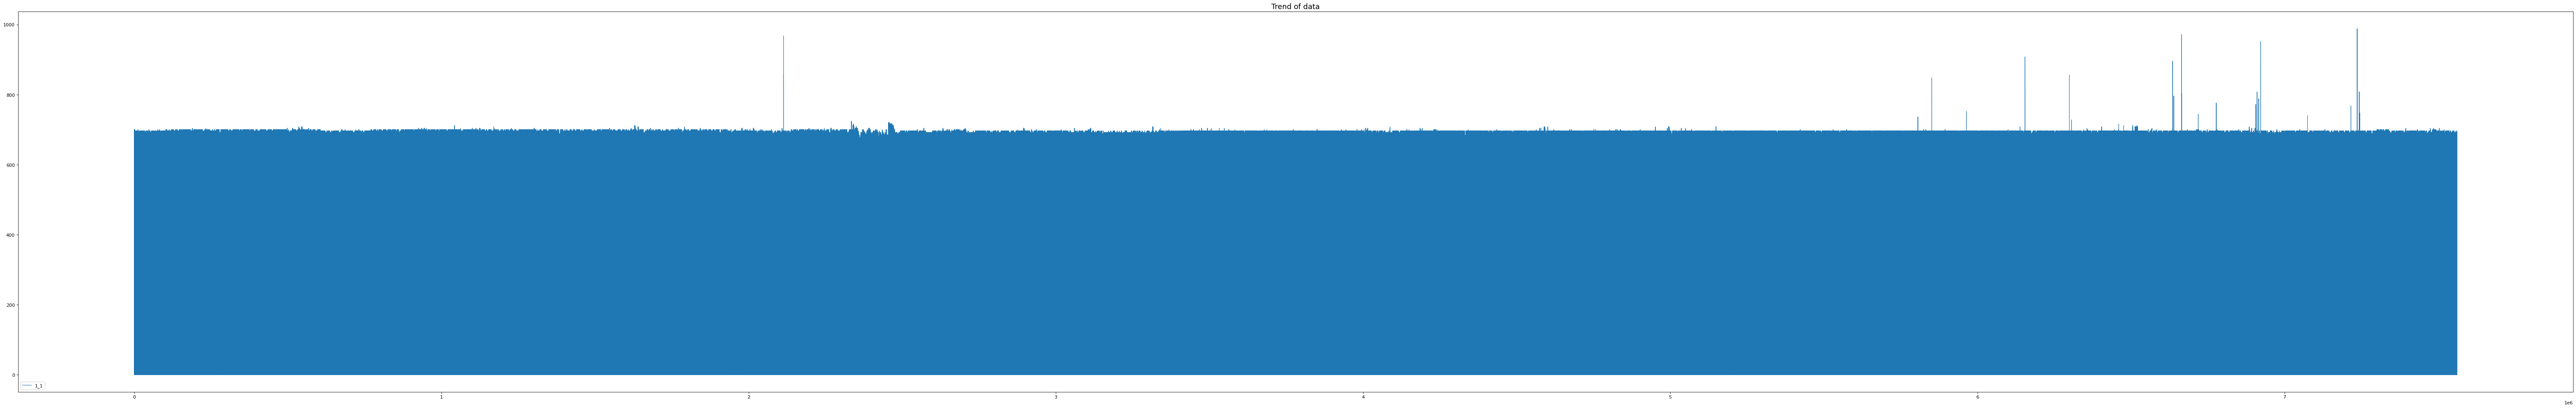

In [41]:
ig, ax = plt.subplots(figsize=(100,15), dpi = 80)
ax.plot(real_full_data['1_1'], label = '1_1', linewidth=1)
# ax.plot(real_full_data['1_2'], label = '1_2', linewidth=1)
# ax.plot(real_full_data['1_3'], label = '1_3', linewidth=1)
# ax.plot(real_full_data['1_8'], label = '1_8', linewidth=1)
# ax.plot(real_full_data['1_9'], label = '1_9', linewidth=1)
# ax.plot(real_full_data['1_10'], label = '1_10', linewidth=1)
# ax.plot(real_full_data['8_1'], label = '8_1', linewidth=1)
# ax.plot(real_full_data['8_2'], label = '8_2', linewidth=1)
# ax.plot(real_full_data['8_3'], label = '8_3', linewidth=1)
# ax.plot(real_full_data['8_4'], label = '8_4', linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Trend of data',fontsize=16)
plt.show();

## 전체 데이터 시각화

In [42]:
# real_full_data.head()
# real_full_data.to_csv('./final_full_data.csv', encoding='utf-8')

In [43]:
status_anormal_idx = real_full_data[real_full_data['result'] == 1].index.tolist()
anormal_idx = []
anormal_idx.append(status_anormal_idx[0])

step = 601  # 더해지는 간격
for i in range(1, int(len(status_anormal_idx) / 601)):
        new_step = i*601
        anormal_idx.append(status_anormal_idx[1+new_step])

print(len(status_anormal_idx))
print(len(anormal_idx))
# print(anormal_idx)

1400330
2330


In [44]:
real_full_data['event_time'] = pd.to_datetime(real_full_data['event_time'])

# Filter rows that start with '2022-12' in 'event_time'
filtered_data = real_full_data[real_full_data['event_time'].dt.strftime('%Y-%m').eq('2023-06')]
filtered_data_end = real_full_data[real_full_data['event_time'].dt.strftime('%Y-%m-%d').eq('2023-06-30')]
# Print the values
print(filtered_data['event_time'])
print(filtered_data_end['event_time'])

6720382   2023-06-01 05:42:00
6720383   2023-06-01 05:42:01
6720384   2023-06-01 05:42:02
6720385   2023-06-01 05:42:03
6720386   2023-06-01 05:42:04
                  ...        
7492061   2023-06-30 22:20:56
7492062   2023-06-30 22:20:57
7492063   2023-06-30 22:20:58
7492064   2023-06-30 22:20:59
7492065   2023-06-30 22:21:00
Name: event_time, Length: 771684, dtype: datetime64[ns]
7439178   2023-06-30 01:32:00
7439179   2023-06-30 01:32:01
7439180   2023-06-30 01:32:02
7439181   2023-06-30 01:32:03
7439182   2023-06-30 01:32:04
                  ...        
7492061   2023-06-30 22:20:56
7492062   2023-06-30 22:20:57
7492063   2023-06-30 22:20:58
7492064   2023-06-30 22:20:59
7492065   2023-06-30 22:21:00
Name: event_time, Length: 52888, dtype: datetime64[ns]


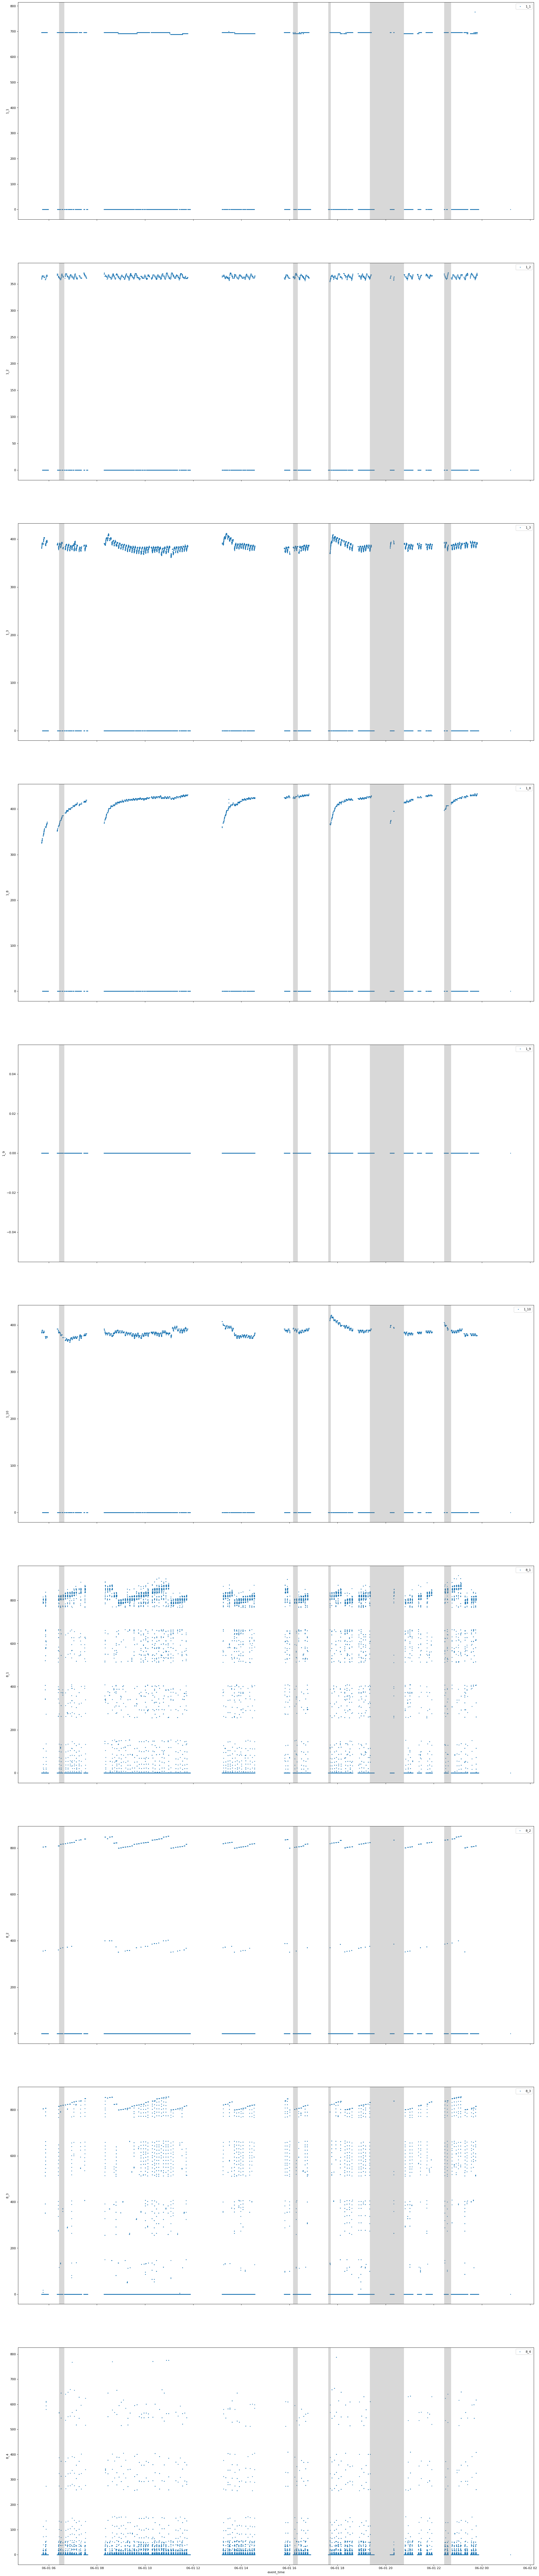

In [45]:
col_name = [ '1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
# Assuming 'event_time' column needs to be converted to datetime
real_full_data['event_time'] = pd.to_datetime(real_full_data['event_time'])

# Set the time range
start_date = '2023-06-01 05:42:00'
end_date = '2023-06-02 01:11:00'  # Adjust the end date as needed

# Filter data for the specified time range
subset_data = real_full_data[(real_full_data['event_time'] >= pd.to_datetime(start_date)) & (real_full_data['event_time'] <= pd.to_datetime(end_date))]

# Get the number of columns
num_cols = len(subset_data.columns)

# Create subplots
fig, axes = plt.subplots(num_cols - 2, 1, figsize=(30, 15 * (num_cols - 2)), dpi=80, sharex=True)

# Columns to exclude
exclude_cols = ['event_time', 'result']

# Plot each column
subplot_index = 0
for col in subset_data.columns:
    if col in exclude_cols:
        continue
    
    axes[subplot_index].scatter(subset_data['event_time'], subset_data[col], label=col_name[subplot_index], linewidth=1,  s=2)
    
    # Highlight anomalies, ensuring indices are within the valid range
    keyerror_idx = []
    for i in anormal_idx:
        try:
            axes[subplot_index].axvspan(
                subset_data['event_time'][i],
                subset_data['event_time'][i + 600],
                facecolor='gray',
                alpha=0.3
            )
        except KeyError:
            # print("KeyError at index:", i, "for column", col_name[subplot_index])
            keyerror_idx.append(i)

    axes[subplot_index].set_ylabel(col_name[subplot_index])
    axes[subplot_index].legend(loc='upper right')
    
    if subplot_index == num_cols - 3:
        axes[subplot_index].set_xlabel('event_time')
    
    subplot_index += 1


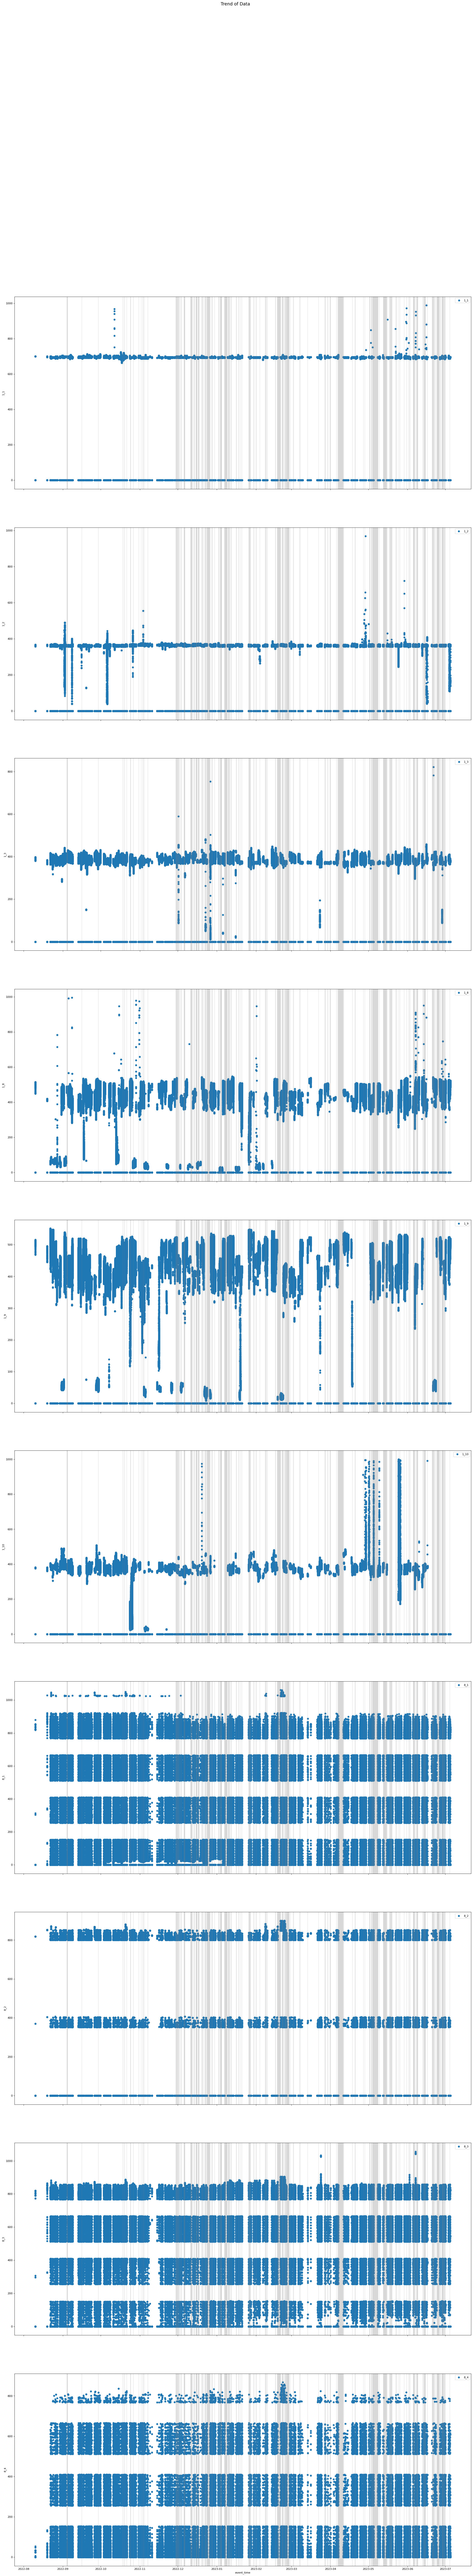

In [48]:
col_name = [ '1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
num_cols = len(real_full_data.columns)  # 열의 개수
fig, axes = plt.subplots(num_cols - 2, 1, figsize=(30, 15 * (num_cols - 2)), dpi=80, sharex=True)

# 제외할 첫 번째 열과 마지막 열
exclude_cols = ['event_time', 'result']

# 각 열에 대한 플롯을 그립니다.
subplot_index = 0
for col in real_full_data.columns:
    if col in exclude_cols:
        continue  # 제외할 열은 건너뜁니다.
        
    axes[subplot_index].scatter(real_full_data['event_time'], real_full_data[col], label=col_name[subplot_index], linewidth=1)
    for i in anormal_idx:
        axes[subplot_index].axvspan(
            real_full_data['event_time'][i],
            real_full_data['event_time'][i + 600],
            facecolor='gray',
            alpha=0.3
        )
    axes[subplot_index].set_ylabel(col_name[subplot_index])
    axes[subplot_index].legend(loc='upper right')
    if subplot_index == num_cols - 3:
        axes[subplot_index].set_xlabel('event_time')
    subplot_index += 1

# 그래프 제목 설정
fig.suptitle('Trend of Data', fontsize=16)

# 그래프 출력
plt.show()

# Dynamic Time Wrapping 적용
- 다른 속도, 움직임을 가진 서로 다르 신호의 시간축에 대한 파장의 유사성을 측정하는 알고리즘
1. Euclidean Distance
   - 각각 시간별 신호 간 MSE를 이용해서 시계열 신호간 유사성을 따짐.
   - 계산이 용이하나 길이가 다른경우 분석이 불가하며 신호의 떨림과 움직임이 심해질수록 결과가 어긋나는 현상이 발생 
3. Nonlinear alignments are possible

In [49]:
pip install fastdtw

Note: you may need to restart the kernel to use updated packages.


In [162]:
pip install statsmodels

  Using cached statsmodels-0.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [255]:
real_full_data.head()

,event_time,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4,result
0,2022-08-10 04:35:00,700.0,366.85,396.6,497.425,504.1,379.2,0.0,0.0,0.0,0.0,0
1,2022-08-10 04:35:01,700.0,366.85,396.6,495.425,505.8,379.1,0.0,0.0,0.0,0.0,0
2,2022-08-10 04:35:02,700.0,366.85,396.7,495.425,505.5,378.8,0.0,0.0,0.0,0.0,0
3,2022-08-10 04:35:03,700.0,366.85,396.7,495.425,505.2,378.8,0.0,0.0,0.0,0.0,0
4,2022-08-10 04:35:04,700.0,366.85,396.7,495.425,504.8,378.6,0.0,0.0,0.0,0.0,0


In [292]:
real_full_data.shape

(7560580, 12)

In [256]:
col_list = real_full_data.columns.to_list()
print(col_list)

['event_time', '1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4', 'result']


In [257]:
import dtw
from fastdtw import fastdtw

# Assuming 'event_time' column needs to be converted to datetime
real_full_data['event_time'] = pd.to_datetime(real_full_data['event_time'])

# Set the time range
start_date = '2023-06-01 05:42:00'
end_date = '2023-06-30 01:32:00'  # Adjust the end date as needed

subset_data = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4', 'result']]

subset_data1 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_1', 'result']]

subset_data2 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_2', 'result']]

subset_data3 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_3', 'result']]

subset_data4 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_8', 'result']]

subset_data5 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_9', 'result']]

subset_data6 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '1_10', 'result']]

subset_data7 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '8_1', 'result']]

subset_data8 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '8_2', 'result']]

subset_data9 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '8_3', 'result']]

subset_data10 = real_full_data.loc[
    (real_full_data['event_time'] >= pd.to_datetime(start_date)) &
    (real_full_data['event_time'] <= pd.to_datetime(end_date)), ['event_time', '8_4', 'result']]

In [258]:
sub_col_list = [subset_data1, subset_data2, subset_data3, subset_data4, subset_data5, subset_data6, subset_data7, subset_data8, subset_data9, subset_data10]

In [259]:
for i,df in enumerate(sub_col_list):
    print(len(df))
    print(len(df)/601)
    print('-'*25)

718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------
718797
1196.0016638935108
-------------------------


In [260]:
subset_data1.head()

,event_time,1_1,result
6720382,2023-06-01 05:42:00,696.0,0
6720383,2023-06-01 05:42:01,696.0,0
6720384,2023-06-01 05:42:02,696.0,0
6720385,2023-06-01 05:42:03,696.0,0
6720386,2023-06-01 05:42:04,696.0,0


In [261]:
# Initialize empty lists to store DataFrames
df_result_0_list = []
df_result_1_list = []

# Process each subset_data DataFrame
for i, subset_data in enumerate(sub_col_list):
    # Filter subset_data for result 0 and result 1
    df_result_0 = subset_data[subset_data['result'] == 0].copy()
    df_result_1 = subset_data[subset_data['result'] == 1].copy()

    # Append to the lists
    df_result_0_list.append(df_result_0)
    df_result_1_list.append(df_result_1)

    # Display lengths of df_result_0 and df_result_1 for each subset_data
    print(f"subset_data{i + 1} - df_result_0: {len(df_result_0)}")
    print(f"subset_data{i + 1} - df_result_1: {len(df_result_1)}")

subset_data1 - df_result_0: 441736
subset_data1 - df_result_1: 277061
subset_data2 - df_result_0: 441736
subset_data2 - df_result_1: 277061
subset_data3 - df_result_0: 441736
subset_data3 - df_result_1: 277061
subset_data4 - df_result_0: 441736
subset_data4 - df_result_1: 277061
subset_data5 - df_result_0: 441736
subset_data5 - df_result_1: 277061
subset_data6 - df_result_0: 441736
subset_data6 - df_result_1: 277061
subset_data7 - df_result_0: 441736
subset_data7 - df_result_1: 277061
subset_data8 - df_result_0: 441736
subset_data8 - df_result_1: 277061
subset_data9 - df_result_0: 441736
subset_data9 - df_result_1: 277061
subset_data10 - df_result_0: 441736
subset_data10 - df_result_1: 277061


In [262]:
for i in range(len(df_result_0_list)):
    globals()[f"sub_data_0_{i + 1}"] = df_result_0_list[i]

for i in range(len(df_result_1_list)):
    globals()[f"sub_data_1_{i + 1}"] = df_result_1_list[i]

In [263]:
sub_data_0 = [sub_data_0_1, sub_data_0_2, sub_data_0_3, sub_data_0_4, sub_data_0_5, sub_data_0_6, sub_data_0_7, sub_data_0_8, sub_data_0_9, sub_data_0_10]
sub_data_1 = [sub_data_1_1, sub_data_1_2, sub_data_1_3, sub_data_1_4, sub_data_1_5, sub_data_1_6, sub_data_1_7, sub_data_1_8, sub_data_1_9, sub_data_1_10]

In [264]:
#true_data의 개수
for i in range(1, 11):
    true_data_col = f'sub_data_0_{i}'
    print(f"{true_data_col} Describe:")
    print(globals()[true_data_col].describe(), '\n')
    print('-  '*20)
    false_data_col = f'sub_data_1_{i}'
    print(f"{false_data_col} Describe:", '\n')
    print(globals()[false_data_col].describe())
    print("\n" + "=" * 100 + "\n") 

sub_data_0_1 Describe:
                          event_time            1_1    result
count                         441736  441736.000000  441736.0
mean   2023-06-11 05:33:29.479372544     420.192341       0.0
min              2023-06-01 05:42:00       0.000000       0.0
25%    2023-06-05 10:29:30.750000128       0.000000       0.0
50%              2023-06-09 16:37:00     692.000000       0.0
75%    2023-06-15 22:23:45.249999872     696.000000       0.0
max              2023-06-30 01:32:00     988.000000       0.0
std                              NaN     339.514865       0.0 

-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
sub_data_1_1 Describe: 

                          event_time            1_1    result
count                         277061  277061.000000  277061.0
mean   2023-06-15 07:26:47.895878144     415.606686       1.0
min              2023-06-01 06:26:00       0.000000       1.0
25%              2023-06-08 04:25:45       0.000000       1.0
50%              2023

In [265]:
print("Unique values in True Data:")
print(sub_data_0_1['1_1'].value_counts())

print("\nUnique values in False Data:")
print(sub_data_1_1['1_1'].value_counts())

Unique values in True Data:
1_1
0.0      174476
696.0    165708
692.0     73945
688.0     15628
700.0     10198
684.0      1709
704.0        62
808.0         3
776.0         2
772.0         1
752.0         1
740.0         1
880.0         1
988.0         1
Name: count, dtype: int64

Unique values in False Data:
1_1
0.0      111246
696.0     96998
692.0     57572
688.0      5986
700.0      4161
704.0       441
684.0       423
708.0       222
788.0         2
772.0         1
952.0         1
932.0         1
832.0         1
768.0         1
744.0         1
880.0         1
988.0         1
748.0         1
740.0         1
Name: count, dtype: int64


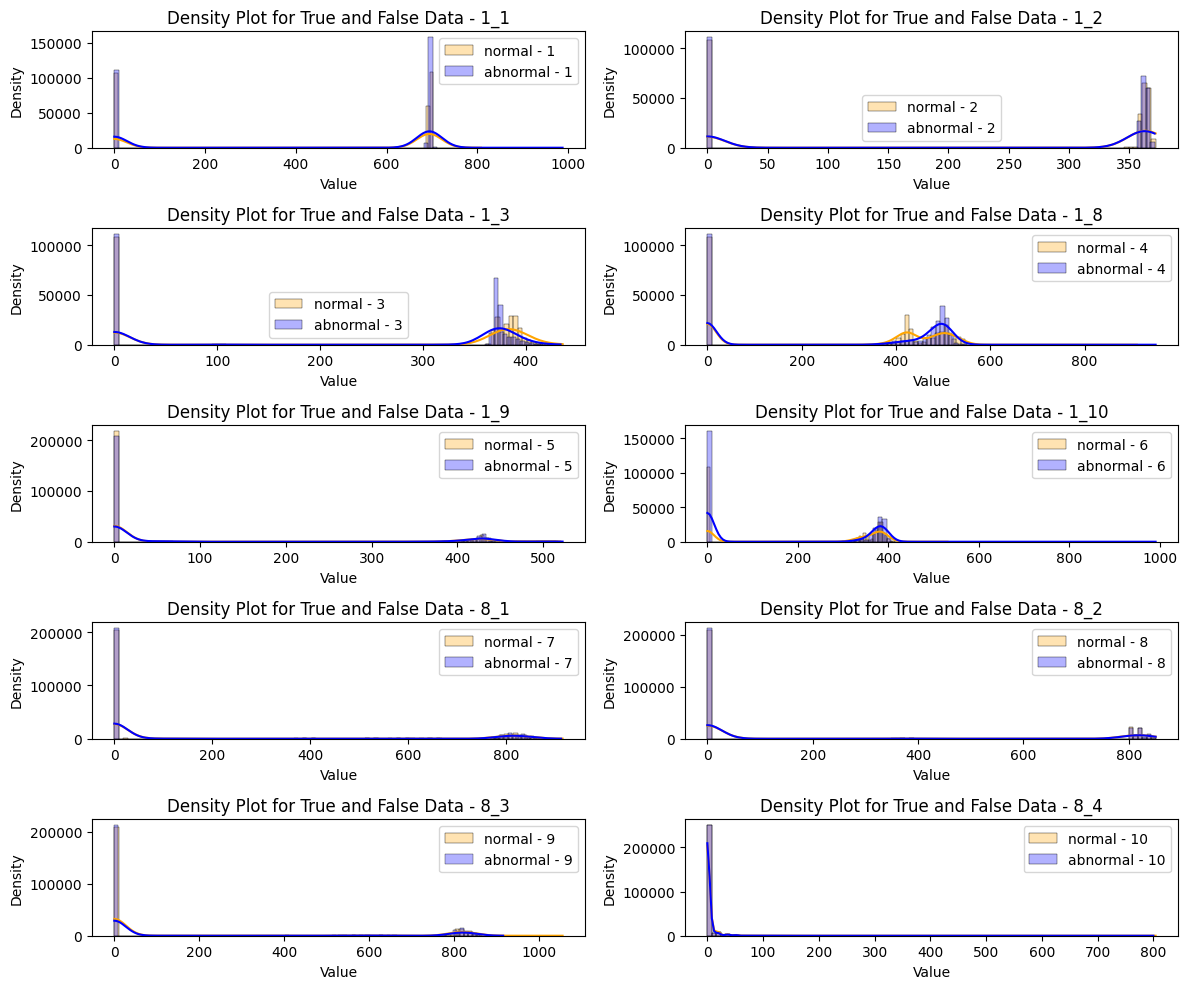

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns

name_list = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
plt.figure(figsize=(12, 10))

for i in range(1, 11):
    plt.subplot(5, 2, i)
    
    true_data_col = globals()[f'sub_data_0_{i}']
    false_data_col = globals()[f'sub_data_1_{i}']
    
    sns.histplot(true_data_col.iloc[:, 1], kde=True, label=f'normal - {i}', color='orange', bins=100, alpha=0.3)
    sns.histplot(false_data_col.iloc[:, 1], kde=True, label=f'abnormal - {i}', color='blue', bins=100, alpha=0.3)

    plt.title(f'Density Plot for True and False Data - {name_list[i-1]}')  # Fix the title argument
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()  # Display legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [267]:
#길이 맞추기
min_lengths = []

for i in range(1, 11):
    ltrue_data_col = f'sub_data_0_{i}'
    lfalse_data_col = f'sub_data_1_{i}'
    
    # Find the minimum length
    min_length = min(len(globals()[ltrue_data_col]), len(globals()[lfalse_data_col]))
    min_lengths.append(min_length)

    # Slice DataFrames to match the minimum length
    globals()[ltrue_data_col] = globals()[ltrue_data_col].iloc[:min_length]
    globals()[lfalse_data_col] = globals()[lfalse_data_col].iloc[:min_length]

    # Display the length after adjustment
    print(f"{ltrue_data_col} Length: {len(globals()[ltrue_data_col]) / 601}")
    print(f"{lfalse_data_col} Length: {len(globals()[lfalse_data_col]) / 601}")
    print("=" * 50)

sub_data_0_1 Length: 461.0
sub_data_1_1 Length: 461.0
sub_data_0_2 Length: 461.0
sub_data_1_2 Length: 461.0
sub_data_0_3 Length: 461.0
sub_data_1_3 Length: 461.0
sub_data_0_4 Length: 461.0
sub_data_1_4 Length: 461.0
sub_data_0_5 Length: 461.0
sub_data_1_5 Length: 461.0
sub_data_0_6 Length: 461.0
sub_data_1_6 Length: 461.0
sub_data_0_7 Length: 461.0
sub_data_1_7 Length: 461.0
sub_data_0_8 Length: 461.0
sub_data_1_8 Length: 461.0
sub_data_0_9 Length: 461.0
sub_data_1_9 Length: 461.0
sub_data_0_10 Length: 461.0
sub_data_1_10 Length: 461.0


In [268]:
# 크게 보기
#true_data의 개수
for i in range(1, 11):
    true_data_col = f'sub_data_0_{i}'
    print(f"{true_data_col} Describe:")
    print(globals()[true_data_col].describe(), '\n')
    print('-  '*20)
    false_data_col = f'sub_data_1_{i}'
    print(f"{false_data_col} Describe:", '\n')
    print(globals()[false_data_col].describe())
    print("\n" + "=" * 100 + "\n") 

sub_data_0_1 Describe:
                          event_time            1_1    result
count                         277061  277061.000000  277061.0
mean   2023-06-06 07:05:53.882863104     424.436900       0.0
min              2023-06-01 05:42:00       0.000000       0.0
25%              2023-06-02 09:05:30       0.000000       0.0
50%              2023-06-07 04:33:00     692.000000       0.0
75%              2023-06-09 13:46:45     696.000000       0.0
max              2023-06-12 18:55:00     808.000000       0.0
std                              NaN     338.474214       0.0 

-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
sub_data_1_1 Describe: 

                          event_time            1_1    result
count                         277061  277061.000000  277061.0
mean   2023-06-15 07:26:47.895878144     415.606686       1.0
min              2023-06-01 06:26:00       0.000000       1.0
25%              2023-06-08 04:25:45       0.000000       1.0
50%              2023

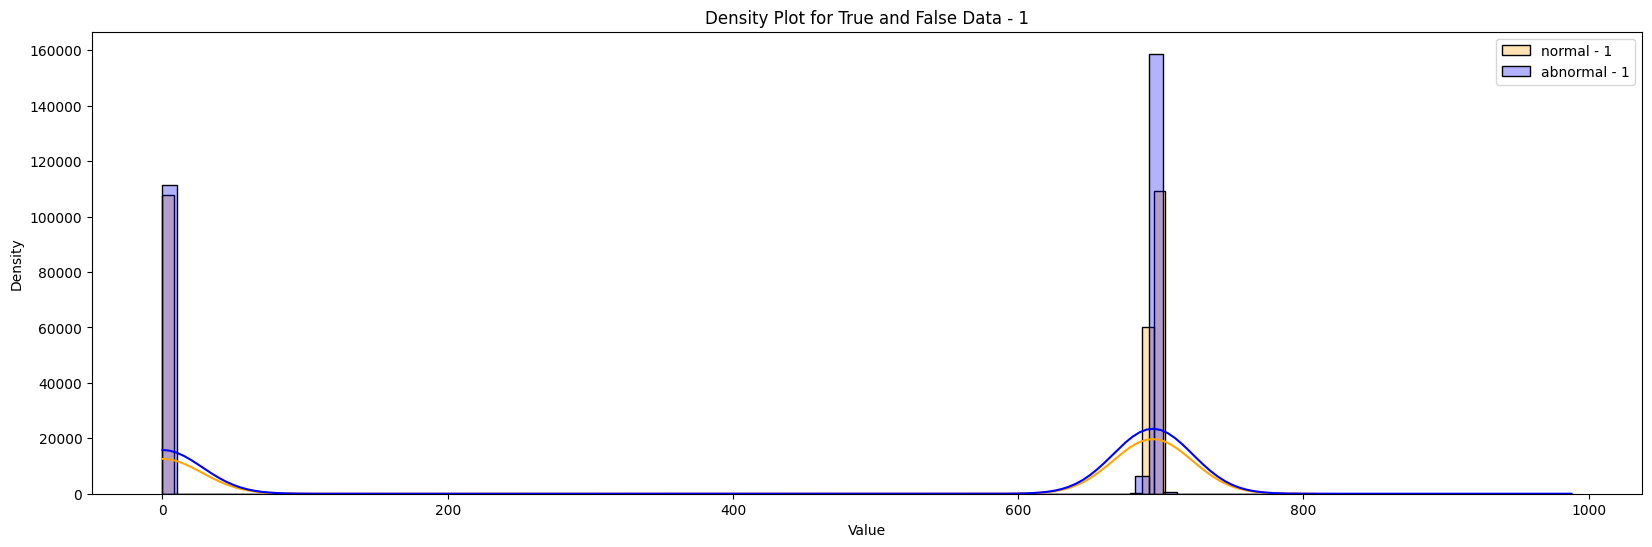

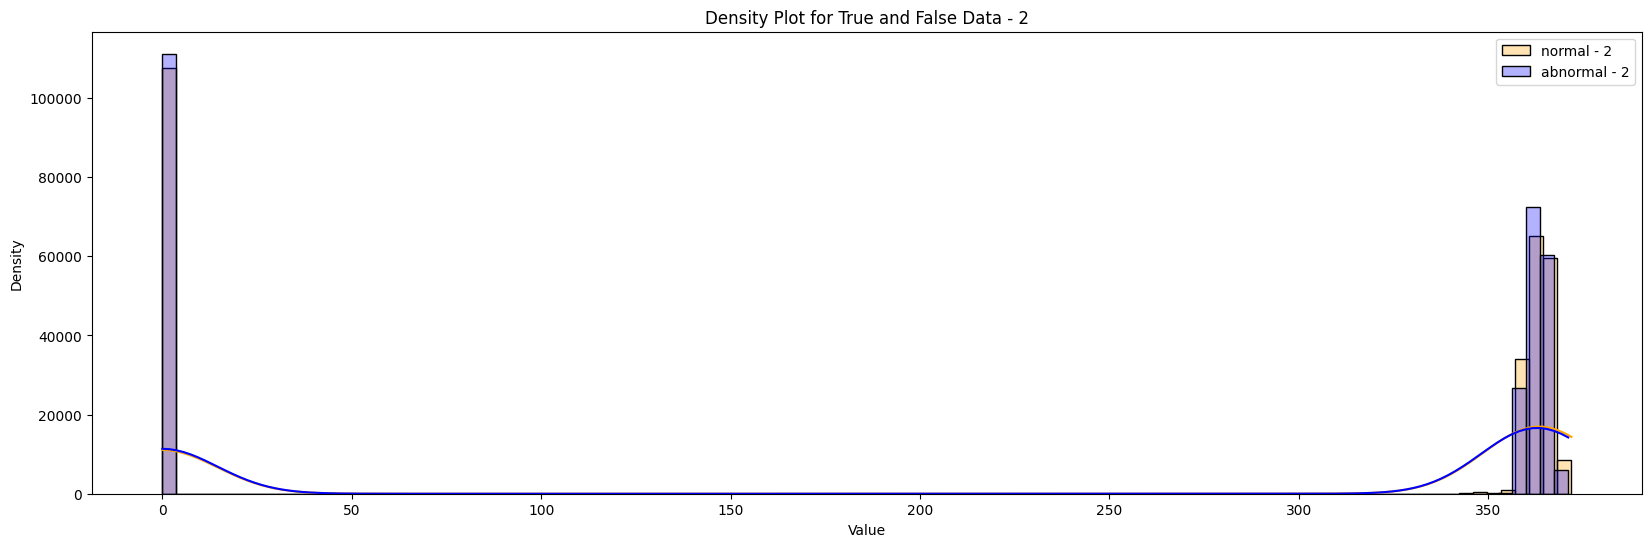

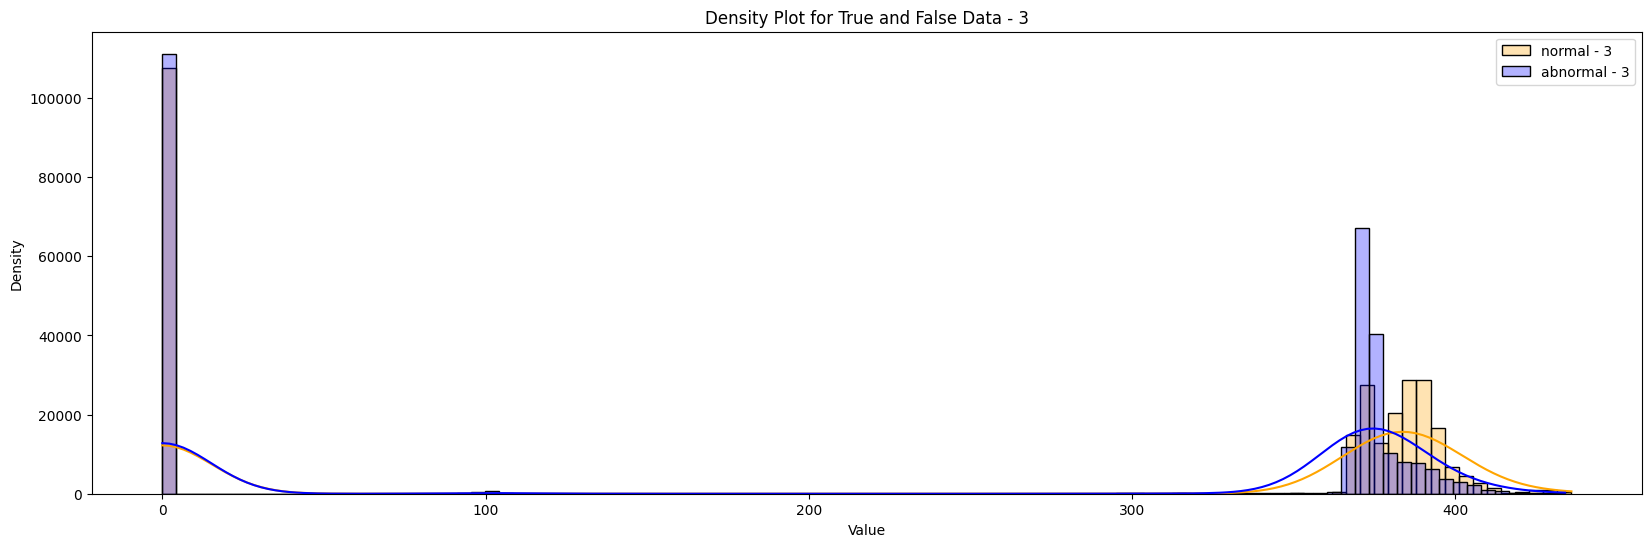

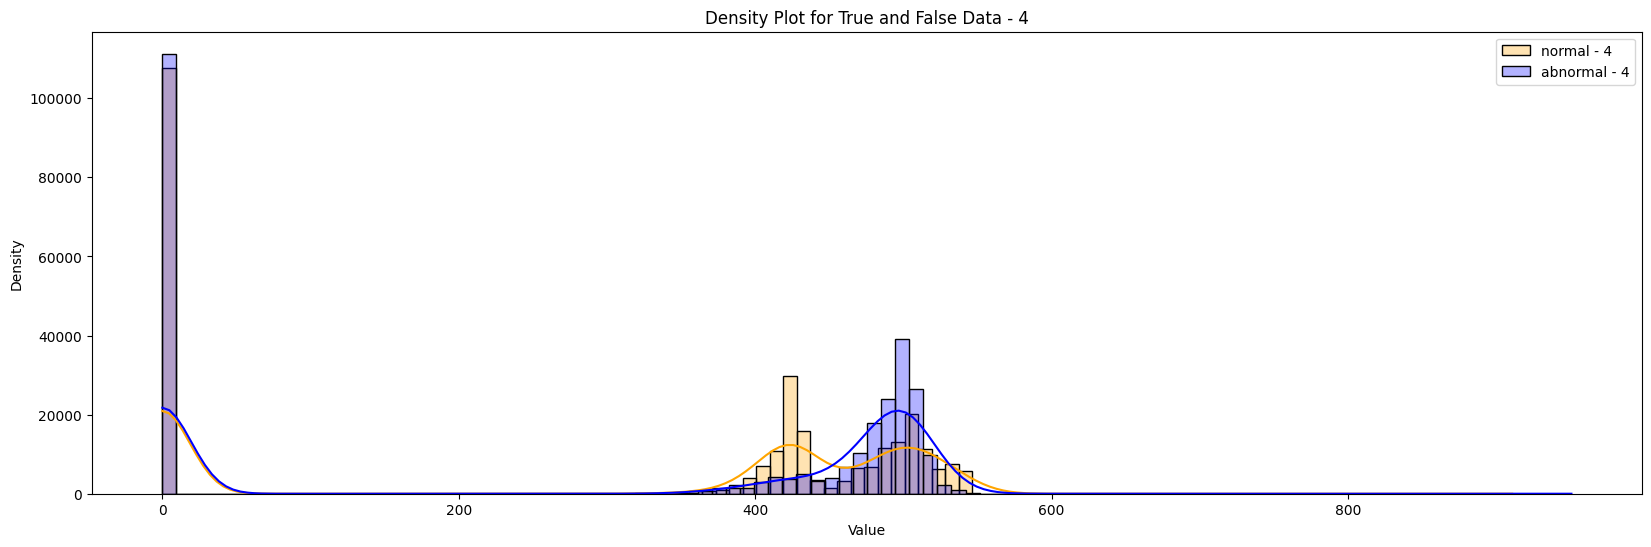

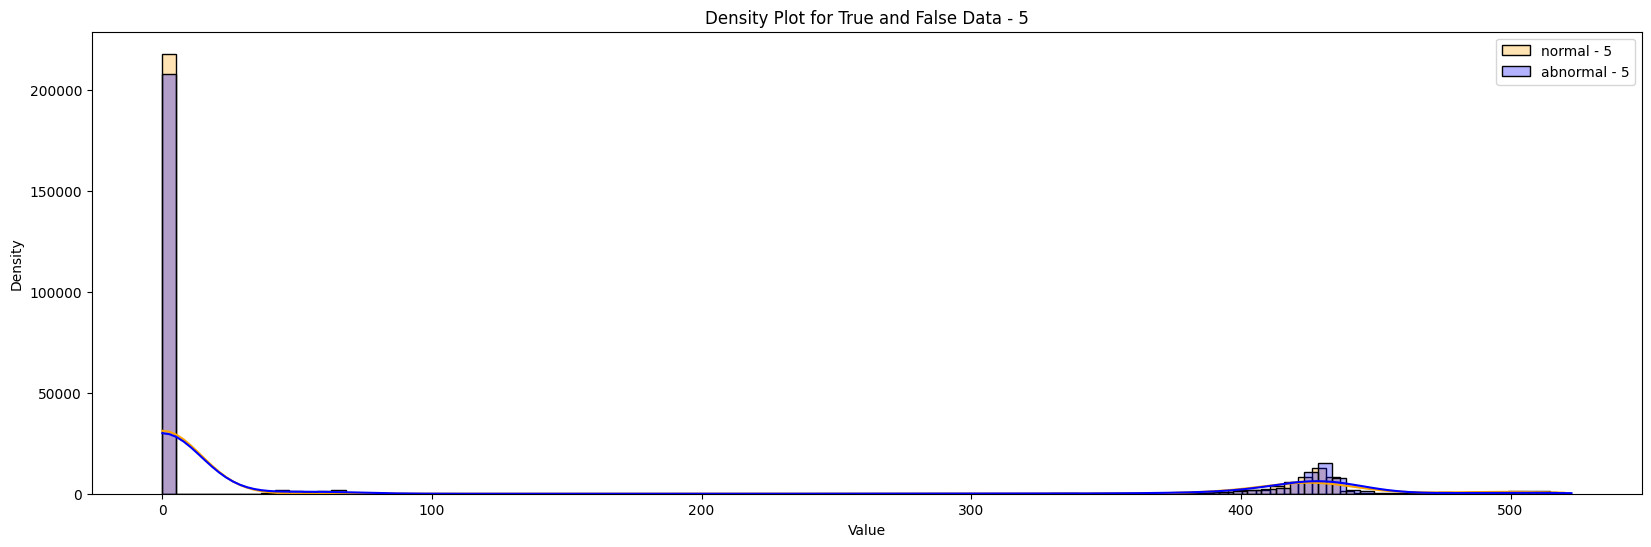

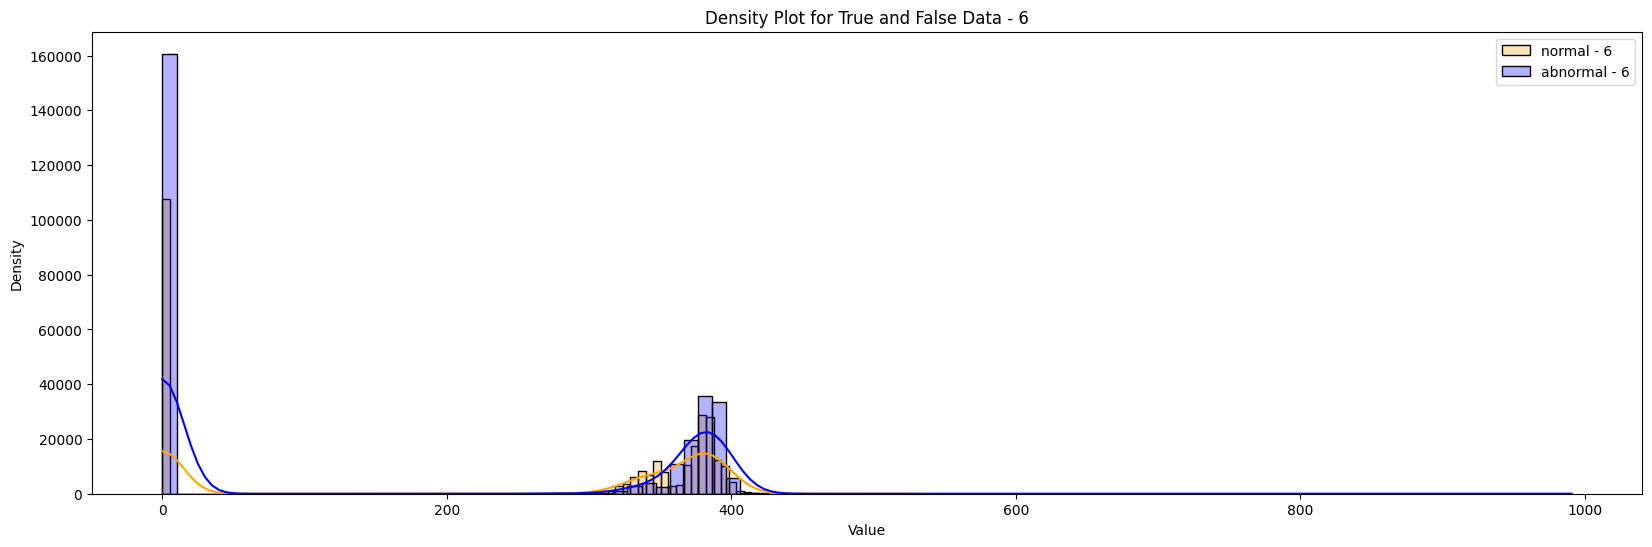

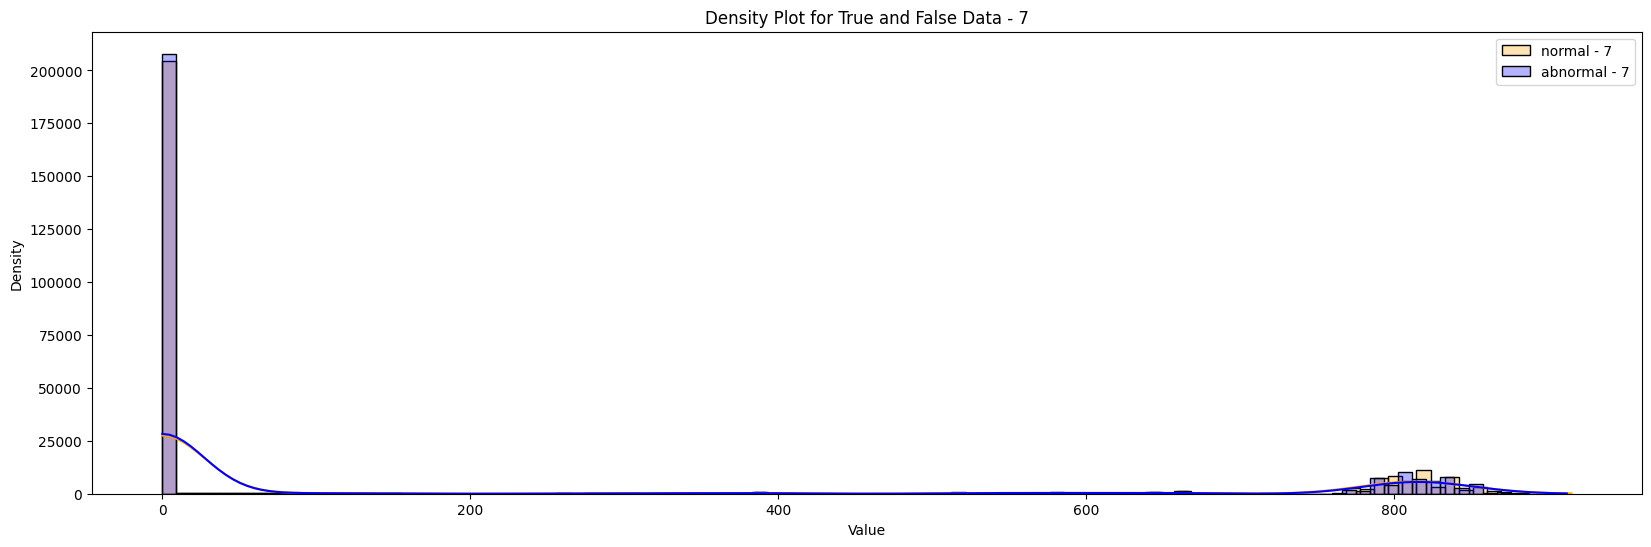

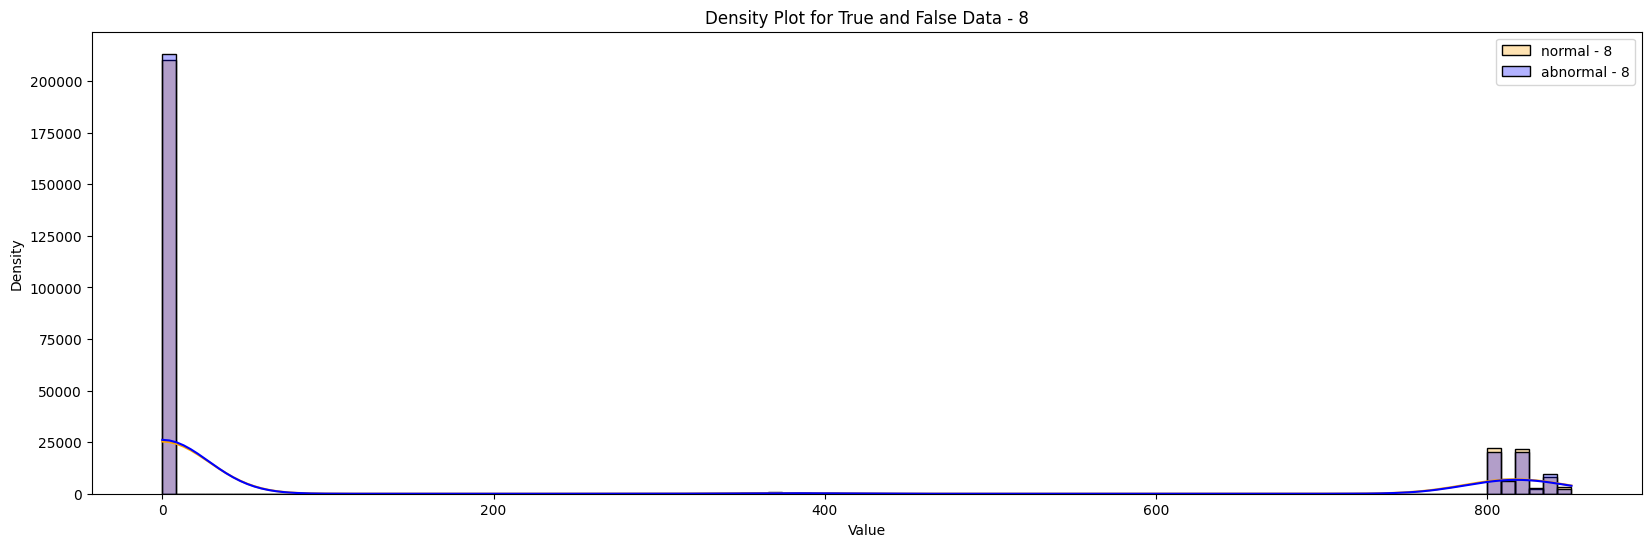

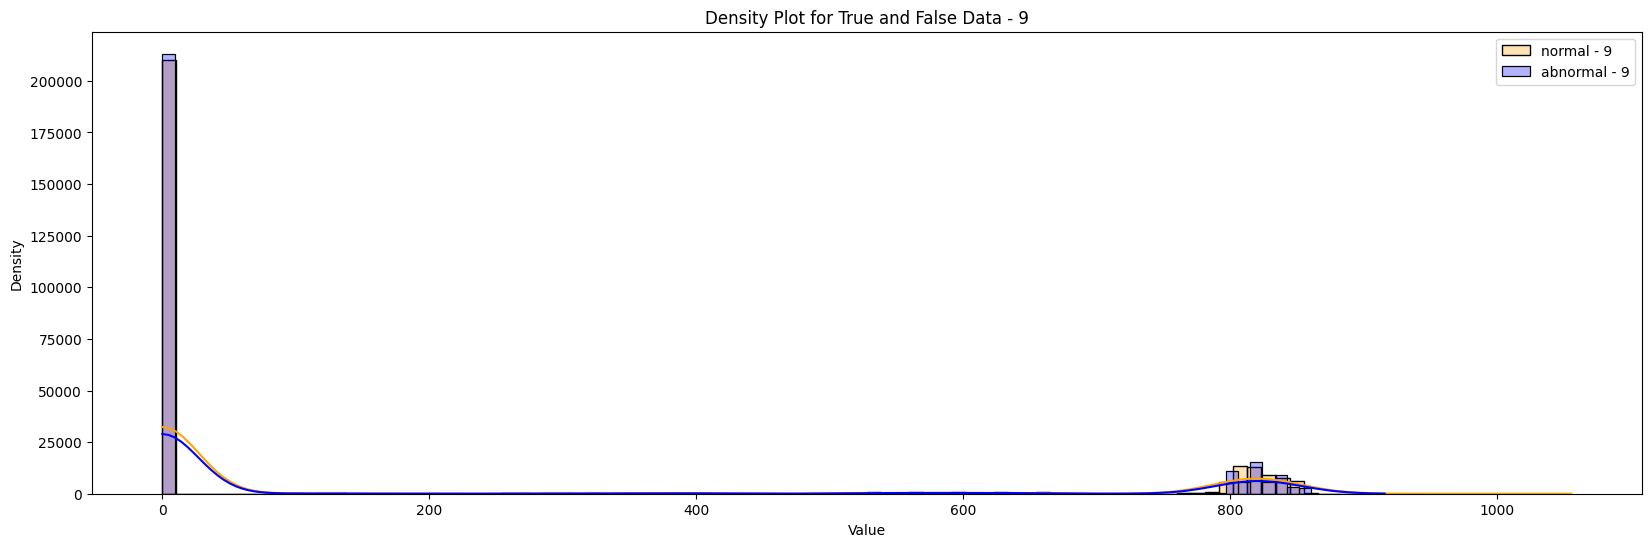

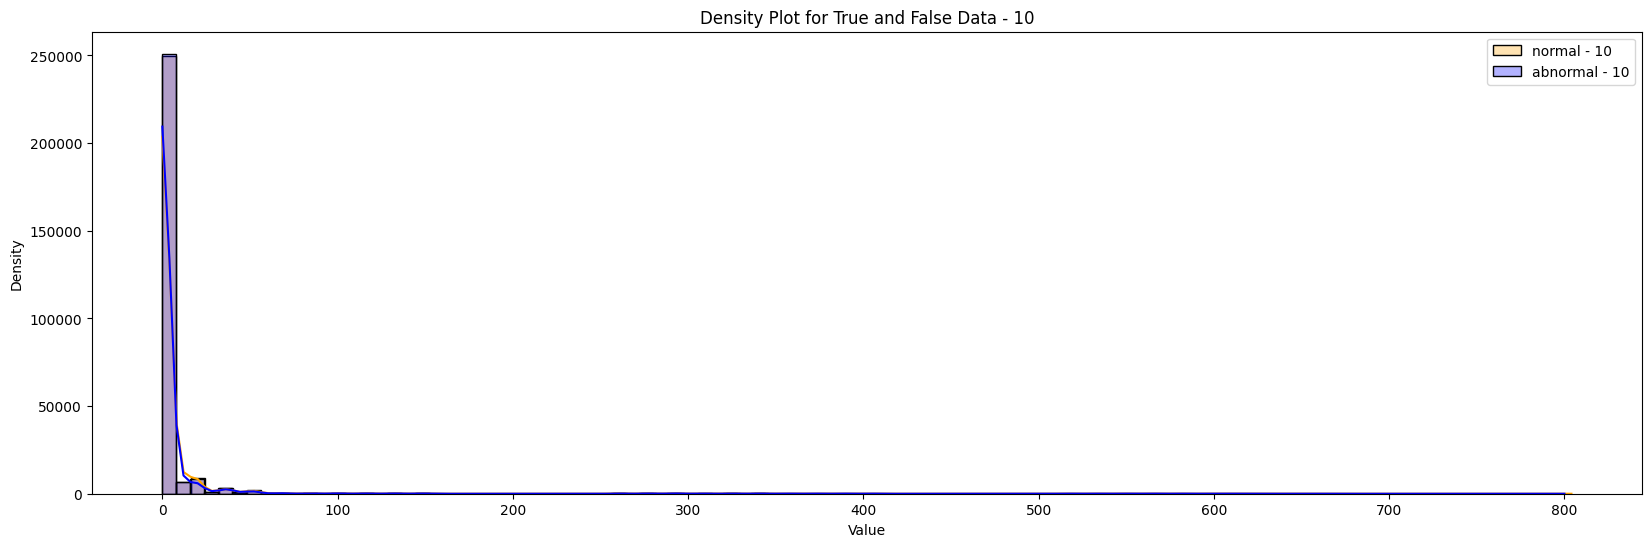

In [269]:
for i in range(1, 11):
    true_data_col = globals()[f'sub_data_0_{i}']
    false_data_col = globals()[f'sub_data_1_{i}']
    
    plt.figure(figsize=(20, 6))
    
    sns.histplot(true_data_col.iloc[:, 1], kde=True, label=f'normal - {i}', color='orange', bins=100, alpha=0.3)
    sns.histplot(false_data_col.iloc[:, 1], kde=True, label=f'abnormal - {i}', color='blue', bins=100, alpha=0.3)
    
    plt.title(f'Density Plot for True and False Data - {i}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()  # 범례 표시
    plt.show()